In [ ]:
#import packages

import numpy as np
import tensorflow as tf

from tensorflow.keras.applications import vgg16, resnet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print(tf.config.list_physical_devices("GPU"))

[]


In [ ]:
#mount drive to import data

from google.colab import drive  #to import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#set train dataset: images and labels

from PIL import Image
import os
# Set the directories for the two classes
class1_dir = "/content/drive/MyDrive/dataset/FIRE-SMOKE-DATASET/Train/Fire"
class3_dir = "/content/drive/MyDrive/dataset/FIRE-SMOKE-DATASET/Train/Neutral"

# Set the image size
image_size = (128,128)

# Set the list of file extensions to include
extensions = [".jpg"]

# Initialize the lists of images and labels
images = []
labels = []

# Load the data from the first class
for filename in os.listdir(class1_dir):
    if any(filename.lower().endswith(ext) for ext in extensions):
        img_path = os.path.join(class1_dir, filename)
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            img = img.resize(image_size)
            img = np.array(img)
            images.append(img)
            labels.append(1)


# Load the data from the second class
for filename in os.listdir(class3_dir):
    if any(filename.lower().endswith(ext) for ext in extensions):
        img_path = os.path.join(class3_dir, filename)
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            img = img.resize(image_size)
            img = np.array(img)
            images.append(img)
            labels.append(0)

# Convert the lists of images and labels to numpy arrays
x_train = np.array(images)
y_train = np.array(labels)

In [ ]:
#set test dataset: images and labels

# Set the directories for the two classes
class1_dir = "/content/drive/MyDrive/dataset/FIRE-SMOKE-DATASET/Test/Fire"
class3_dir = "/content/drive/MyDrive/dataset/FIRE-SMOKE-DATASET/Test/Neutral"

# Set the image size
image_size = (128,128)

# Set the list of file extensions to include
extensions = [".jpg"]

# Initialize the lists of images and labels
images = []
labels = []

# Load the data from the first class
for filename in os.listdir(class1_dir):
    if any(filename.lower().endswith(ext) for ext in extensions):
        img_path = os.path.join(class1_dir, filename)
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            img = img.resize(image_size)
            img = np.array(img)
            images.append(img)
            labels.append(1)

# Load the data from the second class
for filename in os.listdir(class3_dir):
    if any(filename.lower().endswith(ext) for ext in extensions):
        img_path = os.path.join(class3_dir, filename)
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            img = img.resize(image_size)
            img = np.array(img)
            images.append(img)
            labels.append(0)

# Convert the lists of images and labels to numpy arrays
x_test = np.array(images)
y_test = np.array(labels)


In [ ]:
#splitting dataset

# Using the "train_test_split" sklearn function in order to split the train dataset into train/validation subsets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0, shuffle=True)

train_shape = x_train.shape
test_shape = x_test.shape
val_shape = x_val.shape

num_classes = np.max(y_test) + 1

print("Number of train images", train_shape[0])
print("Number of test images", test_shape[0])
print("Number of val images", val_shape[0])
print("Number of classes", num_classes)
print("Image size", train_shape[1:])

Number of train images 1440
Number of test images 200
Number of val images 360
Number of classes 2
Image size (128, 128, 3)


In [ ]:
#data normalization

x_train = x_train / 255.0
x_test = x_test / 255.0
x_val = x_val / 255.0

In [ ]:
##setting hyperparameters

batch_size = 128
epochs = 40
learning_rate = 0.1
lr_decay = 0.1

In [ ]:
#Step decay
def step_decay(epoch):

    lr = learning_rate
    if epoch > 30:
        lr = lr * lr_decay**3
    elif epoch > 20:
        lr = lr * lr_decay**2   
    elif epoch > 10:
        lr = lr * lr_decay

    return lr

#Exponential decay
def exp_decay(epoch):
    
    lr = learning_rate * np.exp(-lr_decay * epoch)

    return lr

In [ ]:
#Transfer learning of VGG16 pretrained model
vgg16_model = vgg16.VGG16(input_shape = (128, 128, 3), include_top = False, weights = "imagenet")

In [ ]:
#model building using tf.keras.Model

def classification_layers(model):
  x = Flatten()(model.layers[-1].output)
  x = Dense(2, activation = 'softmax')(x)
  return x

In [ ]:
output = classification_layers(vgg16_model)

TLmodel = Model(inputs = vgg16_model.input, outputs = output)

TLmodel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
#Freezing the Conv layers
for layer in TLmodel.layers:
  if isinstance(layer, Dense):
    break
  layer.trainable = False

In [ ]:
#Optimizer and loss function

loss = "SparseCategoricalCrossentropy"

opt = SGD(learning_rate=learning_rate)

TLmodel.compile(optimizer=opt, loss = loss, metrics = ["accuracy"])

TL_model_name = "vgg16_transferlearning"

lr_scheduler = LearningRateScheduler(step_decay, verbose=1)
checkpoint = ModelCheckpoint(filepath="./saved_models/{}.hdf5".format(TL_model_name), save_best_only=True, monitor="val_accuracy", verbose=1)
callbacks = [lr_scheduler, checkpoint]

In [ ]:
#Fitting the model

th = TLmodel.fit(x_train, y_train, epochs = epochs, batch_size=batch_size,callbacks=callbacks, validation_data = (x_val, y_val), shuffle = True)


Epoch 1: LearningRateScheduler setting learning rate to 0.1.
Epoch 1/40
12/12 [==============================] - ETA: 0s - loss: 46.4147 - accuracy: 0.5000 
Epoch 1: val_accuracy improved from -inf to 0.48333, saving model to ./saved_models/vgg16_transferlearning.hdf5
12/12 [==============================] - 267s 22s/step - loss: 46.4147 - accuracy: 0.5000 - val_loss: 49.1299 - val_accuracy: 0.4833 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.1.
Epoch 2/40
12/12 [==============================] - ETA: 0s - loss: 36.9275 - accuracy: 0.5063 
Epoch 2: val_accuracy did not improve from 0.48333
12/12 [==============================] - 261s 22s/step - loss: 36.9275 - accuracy: 0.5063 - val_loss: 60.6915 - val_accuracy: 0.4833 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.1.
Epoch 3/40
12/12 [==============================] - ETA: 0s - loss: 19.2834 - accuracy: 0.6403 
Epoch 3: val_accuracy improved from 0.48333 to 0.82778, saving model to

In [ ]:
#Evaluation on the test set

TLmodel = load_model('/content/saved_models/vgg16_transferlearning.hdf5')
TLmodel.evaluate(x_test, y_test)

7/7 [==============================] - 29s 4s/step - loss: 2.2182 - accuracy: 0.8600


[2.2182183265686035, 0.8600000143051147]

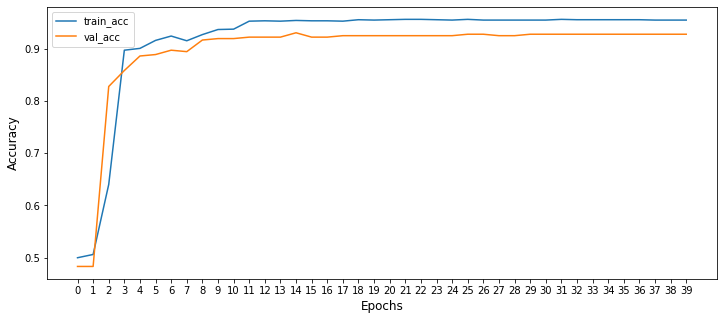

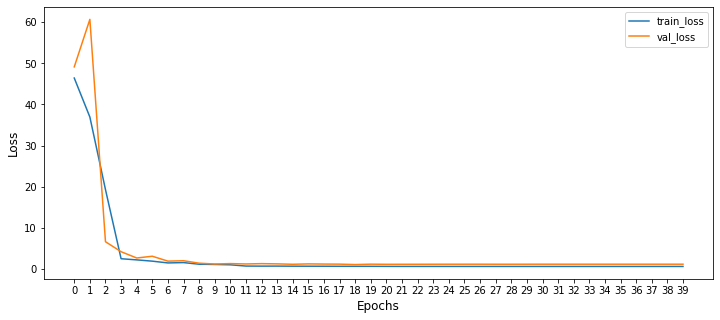

In [ ]:
#Display the Training & Validation plots

plt.figure(figsize=(12, 5))
plt.plot(th.history["accuracy"], label = "train_acc")
plt.plot(th.history["val_accuracy"], label = "val_acc")
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.xticks(range(epochs))
plt.legend()

plt.figure(figsize=(12, 5))
plt.plot(th.history["loss"], label = "train_loss")
plt.plot(th.history["val_loss"], label = "val_loss")
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.xticks(range(epochs))
plt.legend()

plt.show()